In [653]:
import pandas as pd
import numpy as np
import random
import sys

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim import Optimizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

Define the Network

In [654]:
class SmallMLP(nn.Module):
    """A small MLP for small experiments."""

    def __init__(self,
                 model_path: str = r'.\models',
                 model_name: str = 'MLP',
                 num_units: tuple = (8, 100, 1),  # first layer is the input size
                 activation_fn: Module = nn.ReLU,
                 output_fn: Module = nn.Linear,
                 cuda: bool = False):
        super().__init__()
        self.model_name = model_name
        self.model_path = model_path

        # encoder
        layer_stack = []
        for layer, units in enumerate(num_units[1:]):
            activation = activation_fn if layer != len(num_units) else output_fn
            layer_stack.append(nn.Sequential(nn.Linear(in_features=num_units[layer], out_features=units),
                                             activation()))
        self.encoder = nn.ModuleList(layer_stack)

        # Option for CUDA in case we want it. But for small nets usually not good
        if cuda:
            self.to('cuda')

    def forward(self, x: Tensor) -> Tensor:
        for layer in self.encoder:
            x = layer(x)
        return x

    def save_model(self, checkpoint_number: int, optimizer: Optimizer):
        """Saves model and optimizer state."""
        checkpoint_number = str(checkpoint_number)
        saveroot = os.path.join(self.model_path)
        savepath = os.path.join(saveroot, f'{self.model_name}_{checkpoint_number}.pth')
        if not os.path.exists(saveroot):
            os.mkdir(saveroot)

        torch.save({
            'model_name': self.model_name,
            'model_params': self.state_dict(),
            'optimizer': optimizer,
            'optimizer_params': optimizer.state_dict()},
            savepath)
        print(fr'Saved model to {savepath}')

    def load_model(self, checkpoint_number: int, full_loadpath: str = 'default') -> Optimizer:
        """Loads model and optimizer state. Returns optimizer."""
        if full_loadpath != 'default':
            load_directory = full_loadpath
        else:
            load_directory = os.path.join(self.model_path,
                                          f'{self.model_name}_{str(checkpoint_number)}.pth')
        saved_dict = torch.load(load_directory)
        self.load_state_dict(saved_dict['model_params'])
        optimizer = saved_dict['optimizer']
        optimizer.load_state_dict(saved_dict['optimizer_params'])
        return optimizer


Define a dataloader class

In [655]:
# load the x inputs and y labels into a simple pytorch Dataset, for data loading
class CustomDataset(Dataset):
    def __init__(self, input_tensors):
        assert input_tensors[0].size(0) == input_tensors[0].size(0)
        self.input_tensors = input_tensors

    def __getitem__(self, index):
        x = self.input_tensors[0][index]
        y = self.input_tensors[1][index]
        return x, y

    def __len__(self):
        return self.input_tensors[0].size(0)

Load data

In [656]:
pd.set_option('display.max_columns', None)
df_all_merged = pd.read_csv('data/Data_merged_temp_features_v3.csv')
df_all_merged.head()

,Unnamed: 0,org_uuid,org_name,domain,status,founded_on,category_list,category_groups_list,country_code,city,short_description,earliest_funding,time_first_funding,seed_funding,seed_funding_log,series_a_funding_date,time_till_series_a,series_a_funding,series_a_funding_log,seed_n_rounds,series_a_n_rounds,angel_n_rounds,pre_seed_n_rounds,success_flag,time_first_funding_normalised,seed_funding_normalised,series_a_funding_normalised,time_till_series_a_normalised
0,0,86bd89a7-fe3f-12d4-817c-8157c8592194,i.Sec,isec.ng,operating,2013-01-01,"Finance,FinTech",Financial Services,NGA,Lagos,i.Sec is a financial security service that all...,NaN,NaN,0.0,0.000000,NaN,NaN,0.0,0.000000,0.0,0.0,0.0,0.0,0,0.410421,0.000000,0.000000,0.323669
1,1,58fd74f2-9ebb-4a41-cd75-05f9214a9a11,Kukua,kukua.me,operating,2015-01-01,"Content,EdTech,Franchise,Media and Entertainment","Education,Media and Entertainment,Other,Software",KEN,Nairobi,The edutainment company for children of the 21...,2018-11-08,1407 days,2500961.0,6.398107,2022-06-29,2736 days,6000000.0,6.778151,3.0,1.0,0.0,0.0,0,0.300448,0.005558,0.003985,0.619706
2,2,e8772824-d8d5-7636-0bd5-40b76511213b,Airdog,airdog.com,operating,2014-01-01,"Artificial Intelligence,Drones,Robotics","Artificial Intelligence,Consumer Electronics,C...",LVA,Riga,We build smart robots that bring unprecedented...,2015-03-19,442 days,2499329.0,6.397823,2016-07-18,929 days,3506665.0,6.544894,1.0,1.0,0.0,0.0,0,0.094384,0.005554,0.002329,0.210419
3,3,be72d0fa-b5b0-eb2d-f8aa-3cb290f97b33,Ubiq.ai,ubiq.ai,operating,2015-01-01,"Autonomous Vehicles,Car Sharing,Internet,Last ...","Internet Services,Real Estate,Software,Transpo...",AUT,Vienna,Ubiq is shaping the future of urban mobility b...,2015-04-09,98 days,1440559.0,6.158531,NaN,NaN,0.0,0.000000,1.0,0.0,0.0,1.0,0,0.020927,0.003201,0.000000,0.290283
4,4,7c9e6d25-8cf0-80a5-dfd6-d1a21337534d,ANKA,anka.africa,operating,2016-01-01,"Art,E-Commerce,Fashion,Handmade","Clothing and Apparel,Commerce and Shopping,Con...",CIV,Abidjan,"ANKA is a platform to discover, buy, and sell ...",2017-06-21,537 days,8076881.0,6.907244,NaN,NaN,0.0,0.000000,5.0,0.0,0.0,1.0,0,0.114670,0.017949,0.000000,0.557327


In [657]:
drop_col_list = ['earliest_funding', 
                 'domain', 
                 'org_uuid',
                 'country_code',
                 'series_a_funding_log',
                 'org_name',
                 'seed_funding_log',
                 'series_a_funding', 
                 'city', 
                 'short_description', 
                 'founded_on', 
                 'category_list', 
                 'seed_funding', 
                 'time_first_funding', 
                 'status', 
                 'Unnamed: 0', 
                 'time_till_series_a', 
                 'category_groups_list', 
                 'series_a_funding_date']


df_all_clean = df_all_merged.drop(labels = drop_col_list, axis=1)

In [658]:
df_all_clean.head()

,seed_n_rounds,series_a_n_rounds,angel_n_rounds,pre_seed_n_rounds,success_flag,time_first_funding_normalised,seed_funding_normalised,series_a_funding_normalised,time_till_series_a_normalised
0,0.0,0.0,0.0,0.0,0,0.410421,0.000000,0.000000,0.323669
1,3.0,1.0,0.0,0.0,0,0.300448,0.005558,0.003985,0.619706
2,1.0,1.0,0.0,0.0,0,0.094384,0.005554,0.002329,0.210419
3,1.0,0.0,0.0,1.0,0,0.020927,0.003201,0.000000,0.290283
4,5.0,0.0,0.0,1.0,0,0.114670,0.017949,0.000000,0.557327


In [659]:
# data, model wants all features in range [0,1] hence we use max-min norm again
y_all = df_all_clean.pop('success_flag').to_frame()
X_all = df_all_clean
X_all = X_all.to_numpy()
y_all = y_all.to_numpy()

min_max_scaler = preprocessing.MinMaxScaler()
X_all[:,0:4] = min_max_scaler.fit_transform(X_all[:,0:4])
print(X_all.min(axis=0))
print(X_all.max(axis=0))
y_all[:,0:4] = min_max_scaler.fit_transform(y_all[:,0:4])
print(y_all.min(axis=0))
print(y_all.max(axis=0))

# make the train, test, and validation data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

X_train = torch.from_numpy(X_train).to(torch.float32)
Y_train = torch.from_numpy(y_train).to(torch.float32)
X_val = torch.from_numpy(X_val).to(torch.float32)
Y_val = torch.from_numpy(y_val).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(y_test).to(torch.float32)

print(X_train.size(), Y_train.size())
train_set_all = CustomDataset(input_tensors=(X_train, Y_train))
train_loader = DataLoader(train_set_all,
                              batch_size=4,
                              shuffle=True)
validation_set_all = CustomDataset(input_tensors=(X_val, Y_val))
validation_loader = DataLoader(validation_set_all,
                                batch_size=4,
                                shuffle=True)


[0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1.]
[0]
[1]
torch.Size([3647, 8]) torch.Size([3647, 1])


In [660]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)


def training_loop(hyperparams: dict, model, train_loader, device='cpu'):
    """
    :param hyperparams:     Should contain hyperparameters, including loss function, optimizer, number of epochs, etc.
    :param model:
    :param train_loader:
    :param valid_loader:
    :param device:
    :return:
    """
    optimizer = hyperparams['optimizer']
    loss_fn = hyperparams['loss_fn']
    train_loss_values = []
    train_acc_values = []
    val_loss_values = []
    val_acc_values = []
    for epoch in range(hyperparams['num_epochs']):

        # train
        model.train()
        epoch_loss_train = 0.0
        epoch_loss_val = 0.0
        correct_train = 0
        correct_val = 0
        total_count_train = 0
        total_count_val = 0
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate accuracy and loss
            total_count_train += labels.size(0)
            predictions = (outputs > 0.5)
            correct_train += (predictions == labels).sum().item()
            epoch_loss_train += loss.item()

        for data in validation_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # calculate accuracy and loss
            total_count_val += labels.size(0)
            predictions = (outputs > 0.5)
            correct_val += (predictions == labels).sum().item()
            epoch_loss_val += loss.item()

        print(f'Epoch {epoch} train loss: {epoch_loss_train / len(train_loader)}')
        print(f'Epoch {epoch} train accuracy: {100 * correct_train / total_count_train}')
        print(f'Epoch {epoch} val loss: {epoch_loss_val / len(validation_loader)}')
        print(f'Epoch {epoch} val accuracy: {100 * correct_val / total_count_val}')
        if epoch % hyperparams['model_save_interval'] == 0:
            
            model.save_model(checkpoint_number=epoch, optimizer=optimizer)
            train_loss_values.append(epoch_loss_train / len(train_loader))
            train_acc_values.append(correct_train / total_count_train)
            val_loss_values.append(epoch_loss_val / len(validation_loader))
            val_acc_values.append(correct_val / total_count_val)
    return train_loss_values, train_acc_values, val_loss_values, val_acc_values

In [661]:
model = SmallMLP(model_path=r'.\test_models')
hyperparams = {'optimizer': Adam(model.parameters(), lr=1e-5),
                       'loss_fn': torch.nn.BCEWithLogitsLoss(),
                       'num_epochs': 2500,
                       'model_save_interval': 1}

In [662]:
train_loss_values, train_acc_values, val_loss_values, val_acc_values = training_loop(hyperparams, model, train_loader, device='cpu')

Epoch 0 train loss: 0.6931483628587765
Epoch 0 train accuracy: 64.68330134357005
Epoch 0 val loss: 0.6931471824645996
Epoch 0 val accuracy: 64.63815789473684
Saved model to .\test_models/MLP_0.pth
Epoch 1 train loss: 0.6931486121264466
Epoch 1 train accuracy: 64.68330134357005
Epoch 1 val loss: 0.6931471824645996
Epoch 1 val accuracy: 64.63815789473684
Saved model to .\test_models/MLP_1.pth
Epoch 2 train loss: 0.6931482511000675
Epoch 2 train accuracy: 64.68330134357005
Epoch 2 val loss: 0.6931471824645996
Epoch 2 val accuracy: 64.63815789473684
Saved model to .\test_models/MLP_2.pth
Epoch 3 train loss: 0.6931482595309877
Epoch 3 train accuracy: 64.68330134357005
Epoch 3 val loss: 0.6931471824645996
Epoch 3 val accuracy: 64.63815789473684
Saved model to .\test_models/MLP_3.pth
Epoch 4 train loss: 0.6931475223156444
Epoch 4 train accuracy: 64.68330134357005
Epoch 4 val loss: 0.6931478651730638
Epoch 4 val accuracy: 64.63815789473684
Saved model to .\test_models/MLP_4.pth
Epoch 5 train l

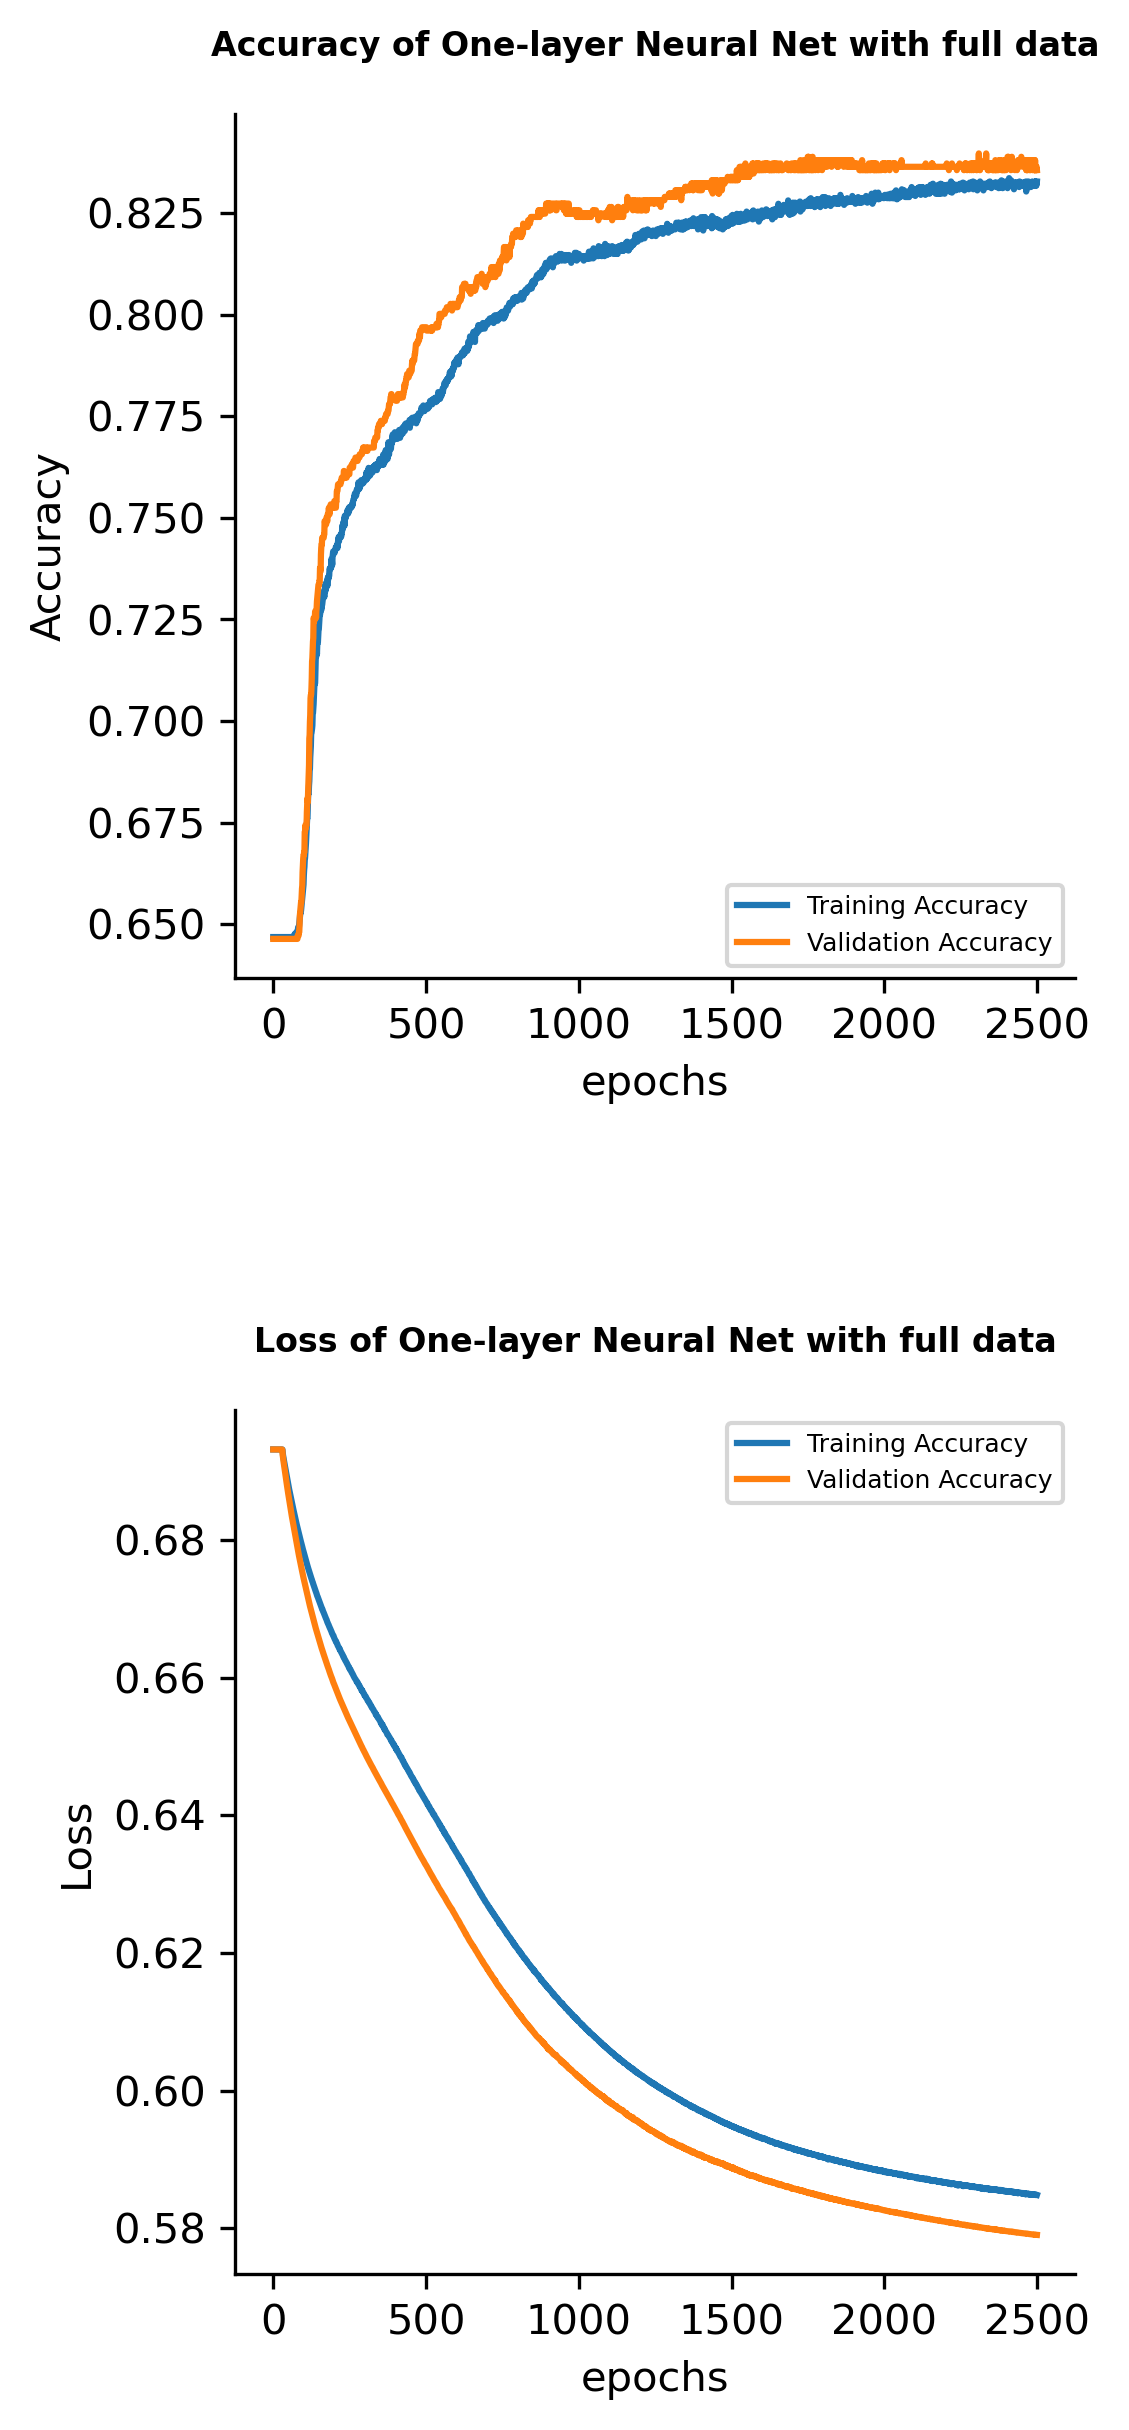

In [669]:
# Define figure
fig, axes = plt.subplots(2, 1, figsize=(4, 9), dpi=300, facecolor='w')

train_loss_values = np.array(train_loss_values)
train_acc_values = np.array(train_acc_values)
val_loss_values = np.array(val_loss_values)
val_acc_values = np.array(val_acc_values)

for i, ax in enumerate(axes.flatten()):

    if (i % 2) == 0:

        train_acc, = ax.plot(np.arange(0,2500,1),train_acc_values, label='Training Accuracy')
        val_acc, = ax.plot(np.arange(0,2500,1),val_acc_values, label='Validation Accuracy')

        # make legend 
        ax.legend(handles=[train_acc, val_acc], fontsize=6)
        
        # Hide the right and top spines
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        
        # make the labels
        ax.set_xlabel("epochs")
        ax.set_ylabel("Accuracy")
        ax.set_title('Accuracy of One-layer Neural Net with full data', fontweight='bold', fontsize=8, pad=14)

    else:
        train_loss, = ax.plot(np.arange(0,2500,1),train_loss_values, label='Training Accuracy')
        val_loss, = ax.plot(np.arange(0,2500,1),val_loss_values, label='Validation Accuracy')

        # make legend 
        ax.legend(handles=[train_loss, val_loss], fontsize=6)
        
        # Hide the right and top spines
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        
        # make the labels
        ax.set_xlabel("epochs")
        ax.set_ylabel("Loss")
        ax.set_title('Loss of One-layer Neural Net with full data', fontweight='bold', fontsize=8, pad=14)


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)

In [670]:
drop_col_list_v2 = ['earliest_funding', 
                    'domain', 
                    'org_uuid',
                    'country_code',
                    'series_a_funding_log',
                    'org_name',
                    'seed_funding_log',
                    'series_a_funding', 
                    'city', 
                    'short_description', 
                    'founded_on', 
                    'category_list', 
                    'seed_funding', 
                    'time_first_funding', 
                    'status', 
                    'Unnamed: 0', 
                    'time_till_series_a', 
                    'category_groups_list', 
                    'series_a_funding_date',
                    'series_a_n_rounds', 
                    'series_a_funding_normalised']

df_all_clean_reduced = df_all_merged.drop(labels = drop_col_list_v2, axis=1)

In [671]:
# data, model wants all features in range [0,1] hence we use max-min norm again
y_all = df_all_clean_reduced.pop('success_flag').to_frame()
X_all = df_all_clean_reduced
X_all = X_all.to_numpy()
y_all = y_all.to_numpy()

min_max_scaler = preprocessing.MinMaxScaler()
X_all[:,0:4] = min_max_scaler.fit_transform(X_all[:,0:4])
print(X_all.min(axis=0))
print(X_all.max(axis=0))
y_all[:,0:4] = min_max_scaler.fit_transform(y_all[:,0:4])
print(y_all.min(axis=0))
print(y_all.max(axis=0))

# make the train, test, and validation data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

X_train = torch.from_numpy(X_train).to(torch.float32)
Y_train = torch.from_numpy(y_train).to(torch.float32)
X_val = torch.from_numpy(X_val).to(torch.float32)
Y_val = torch.from_numpy(y_val).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
Y_test = torch.from_numpy(y_test).to(torch.float32)

print(X_train.size(), Y_train.size())
train_set_all = CustomDataset(input_tensors=(X_train, Y_train))
train_loader = DataLoader(train_set_all,
                              batch_size=4,
                              shuffle=True)
validation_set_all = CustomDataset(input_tensors=(X_val, Y_val))
validation_loader = DataLoader(validation_set_all,
                                batch_size=4,
                                shuffle=True)

[0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1.]
[0]
[1]
torch.Size([3647, 6]) torch.Size([3647, 1])


In [672]:
class SmallMLPv2(nn.Module):
    """A small MLP for small experiments."""

    def __init__(self,
                 model_path: str = r'.\models',
                 model_name: str = 'MLP',
                 num_units: tuple = (6, 100, 1),  # first layer is the input size
                 activation_fn: Module = nn.ReLU,
                 output_fn: Module = nn.Linear,
                 cuda: bool = False):
        super().__init__()
        self.model_name = model_name
        self.model_path = model_path

        # encoder
        layer_stack = []
        for layer, units in enumerate(num_units[1:]):
            activation = activation_fn if layer != len(num_units) else output_fn
            layer_stack.append(nn.Sequential(nn.Linear(in_features=num_units[layer], out_features=units),
                                             activation()))
        self.encoder = nn.ModuleList(layer_stack)

        # Option for CUDA in case we want it. But for small nets usually not good
        if cuda:
            self.to('cuda')

    def forward(self, x: Tensor) -> Tensor:
        for layer in self.encoder:
            x = layer(x)
        return x

    def save_model(self, checkpoint_number: int, optimizer: Optimizer):
        """Saves model and optimizer state."""
        checkpoint_number = str(checkpoint_number)
        saveroot = os.path.join(self.model_path)
        savepath = os.path.join(saveroot, f'{self.model_name}_{checkpoint_number}.pth')
        if not os.path.exists(saveroot):
            os.mkdir(saveroot)

        torch.save({
            'model_name': self.model_name,
            'model_params': self.state_dict(),
            'optimizer': optimizer,
            'optimizer_params': optimizer.state_dict()},
            savepath)
        print(fr'Saved model to {savepath}')

    def load_model(self, checkpoint_number: int, full_loadpath: str = 'default') -> Optimizer:
        """Loads model and optimizer state. Returns optimizer."""
        if full_loadpath != 'default':
            load_directory = full_loadpath
        else:
            load_directory = os.path.join(self.model_path,
                                          f'{self.model_name}_{str(checkpoint_number)}.pth')
        saved_dict = torch.load(load_directory)
        self.load_state_dict(saved_dict['model_params'])
        optimizer = saved_dict['optimizer']
        optimizer.load_state_dict(saved_dict['optimizer_params'])
        return optimizer


In [673]:
model = SmallMLPv2(model_path=r'.\test_modelsv2')
hyperparams = {'optimizer': Adam(model.parameters(), lr=1e-5),
                       'loss_fn': torch.nn.BCEWithLogitsLoss(),
                       'num_epochs': 2500,
                       'model_save_interval': 1}

In [668]:
train_loss_values_v2, train_acc_values_v2, val_loss_values_v2, val_acc_values_v2 = training_loop(hyperparams, model, train_loader, device='cpu')

Epoch 0 train loss: 0.7109547429309603
Epoch 0 train accuracy: 64.68330134357005
Epoch 0 val loss: 0.7037840424791763
Epoch 0 val accuracy: 64.63815789473684
Saved model to .\test_modelsv2/MLP_0.pth
Epoch 1 train loss: 0.6977855615448534
Epoch 1 train accuracy: 64.68330134357005
Epoch 1 val loss: 0.6932319453672359
Epoch 1 val accuracy: 64.63815789473684
Saved model to .\test_modelsv2/MLP_1.pth
Epoch 2 train loss: 0.6928658887351814
Epoch 2 train accuracy: 64.68330134357005
Epoch 2 val loss: 0.6925671237863993
Epoch 2 val accuracy: 64.63815789473684
Saved model to .\test_modelsv2/MLP_2.pth
Epoch 3 train loss: 0.6925478990663562
Epoch 3 train accuracy: 64.68330134357005
Epoch 3 val loss: 0.6923508187265772
Epoch 3 val accuracy: 64.63815789473684
Saved model to .\test_modelsv2/MLP_3.pth
Epoch 4 train loss: 0.6923407250851915
Epoch 4 train accuracy: 64.68330134357005
Epoch 4 val loss: 0.6921190129298913
Epoch 4 val accuracy: 64.63815789473684
Saved model to .\test_modelsv2/MLP_4.pth
Epoch

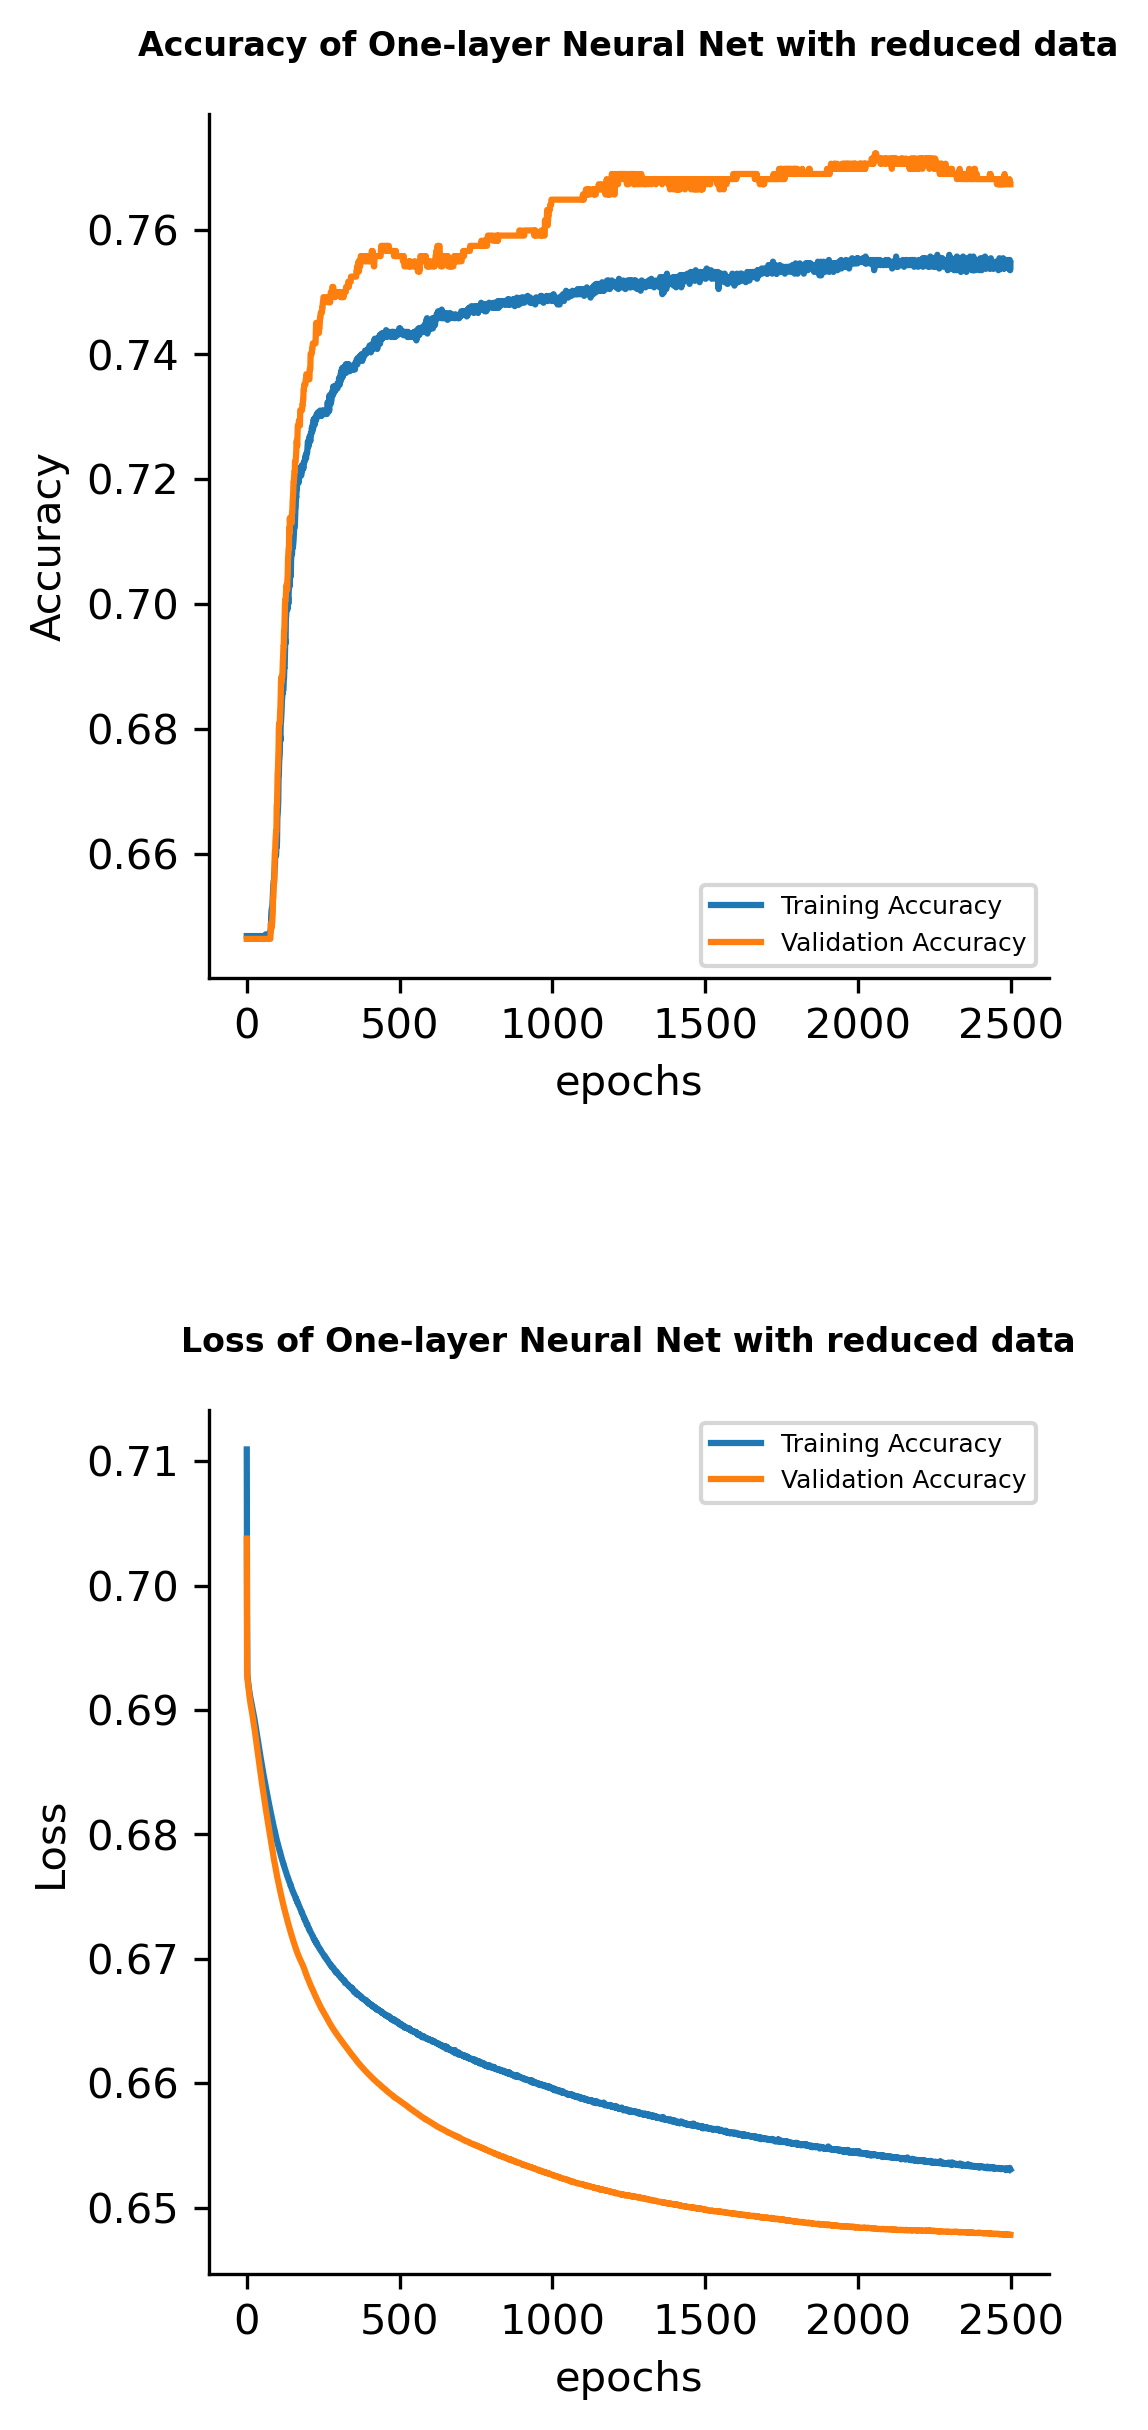

In [674]:
# Define figure
fig, axes = plt.subplots(2, 1, figsize=(4, 9), dpi=300, facecolor='w')

train_loss_values = np.array(train_loss_values_v2)
train_acc_values = np.array(train_acc_values_v2)
val_loss_values = np.array(val_loss_values_v2)
val_acc_values = np.array(val_acc_values_v2)

for i, ax in enumerate(axes.flatten()):

    if (i % 2) == 0:

        train_acc, = ax.plot(np.arange(0,2500,1),train_acc_values, label='Training Accuracy')
        val_acc, = ax.plot(np.arange(0,2500,1),val_acc_values, label='Validation Accuracy')

        # make legend 
        ax.legend(handles=[train_acc, val_acc], fontsize=6)
        
        # Hide the right and top spines
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        
        # make the labels
        ax.set_xlabel("epochs")
        ax.set_ylabel("Accuracy")
        ax.set_title('Accuracy of One-layer Neural Net with reduced data', fontweight='bold', fontsize=8, pad=14)

    else:
        train_loss, = ax.plot(np.arange(0,2500,1),train_loss_values, label='Training Accuracy')
        val_loss, = ax.plot(np.arange(0,2500,1),val_loss_values, label='Validation Accuracy')

        # make legend 
        ax.legend(handles=[train_loss, val_loss], fontsize=6)
        
        # Hide the right and top spines
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
        
        # make the labels
        ax.set_xlabel("epochs")
        ax.set_ylabel("Loss")
        ax.set_title('Loss of One-layer Neural Net with reduced data', fontweight='bold', fontsize=8, pad=14)


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.8, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.5)